In [1]:
import numpy as np
import cvxpy as cvx
from scipy import sparse

In [2]:
from imTools import *

In [3]:
# target = readImage('images/BrainProtonDensitySliceShifted13x17y.png', (100,100))
# base = readImage('images/BrainT1Slice.png', (100,100))
target = readImage('images/BrainProtonDensitySliceShifted13x17y.png', (75,75))
base = readImage('images/BrainT1Slice.png', (75,75))
(m, n, _) = base.shape

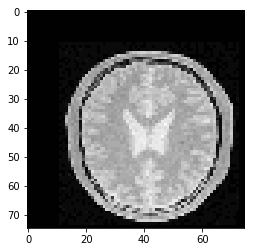

In [4]:
plt.imshow(target)
plt.show()

In [5]:
from Taylor08 import *

SyntaxError: invalid syntax (Taylor08.py, line 40)

In [ ]:
px = np.random.random(19)*0.5
py = np.random.random(19)*0.5
p = np.concatenate((px,py), axis=0)

In [ ]:
D = gaussianDeformImage(base, 10, 4, px, py)

In [ ]:
plt.imshow(D)
plt.show()

In [ ]:
(dIm, Ax, Ay, Iz, b, Dx, Dy, C) = Taylor08(target, base, 4, px, py)

In [ ]:
plt.imshow(dIm)
plt.show()

In [ ]:
z = cvx.Variable(m*n)
obj = cvx.Minimize(sum(z))
constraints = [(Ax @ C @ px) + (Ay @ C @ py) - Iz@z <= b]
prob = cvx.Problem(obj, constraints)
result = prob.solve()

In [ ]:
A = (Ax @ C @ px) + (Ay @ C @ py) - Iz@(z.value)
s = b - A + 1/(10)**8
d = sparse.diags(s**(-1))
d2 = d**2

In [ ]:
D1 = Ax.T @ d2 @ Ax
D2 = Ay.T @ d2 @ Ax
D3 = Ay.T @ d2 @ Ay
D4 = Iz.T @ d2 @ Ax
D5 = Iz.T @ d2 @ Ay
D6 = Iz.T @ d2 @ Iz
# With no lower / upper bounds on Dx, Dy

In [ ]:
# Constructs Hp
Hpx = C.T@D1@C
Hpxpy = C.T @ D2 @ C
Hpy = C.T@D3@C

Hp1 = np.concatenate((Hpx, Hpxpy), axis = 1)
Hp2 = np.concatenate((Hpxpy, Hpy), axis = 1)
Hp = np.concatenate((Hp1, Hp2), axis = 0)

In [ ]:
# Construct Hz
Hz1 = D4 @ C
Hz2 = D5 @ C

Hz = np.concatenate((Hz1, Hz2), axis = 1)

In [ ]:
tau = 1
gz = tau - Iz.T@s**(-1)
gpx =  -1 * C.T@Ax.T@s**(-1)
gpy =  -1 * C.T@Ay.T@s**(-1)
gp = np.concatenate((gpx, gpy), axis = 0)
g = np.concatenate((gp, gz), axis = 0)
Dinv = sparse.linalg.inv(D6)

dp = np.linalg.solve(Hp - Hz.T @ Dinv @ Hz, gp - Hz.T @ Dinv @ gz)
dz = sparse.linalg.inv(D6)@(gz - Hz @ dp)
delta = np.concatenate((dp, dz), axis = 0)

lambdasqr = -1 * g.T @ delta

In [ ]:
p + dp
im = gaussianDeformImage(base, 10, 4, (p + dp)[:19], (p + dp)[19:])
plt.imshow(im)
plt.show()
# (im, Ax, Ay, Iz, b, Dx, Dy, C) = getConstraintCoeffs2(target, base, 10, 4, 4, (p + dp)[:19], (p + dp)[19:])

In [ ]:
for i in range(10):
    
    (im, Ax, Ay, Iz, b, Dx, Dy, C) = getConstraintCoeffs2(target, base, 10, 4, 10, p[:19], p[19:])
    plt.imshow(im)
    plt.show()
    
    tau = 10 * (i+1)
    
    print("Minimizing z...")
    ztime = time.time()
    z = cvx.Variable(m*n)
    obj = cvx.Minimize(sum(tau * z))
    constraints = [(Ax @ C @ p[:19]) + (Ay @ C @ p[19:]) - Iz@(tau * z) <= b]
    prob = cvx.Problem(obj, constraints)
    result = prob.solve()
    print("Done. Time elapsed: ", time.time() - ztime, "\n\n")
    
    A = (Ax @ C @ px) + (Ay @ C @ py) - Iz@(z.value)
    s = b - A + 1/(10)**8
    d = sparse.diags(s**(-1))
    d2 = d**2

    (Hp, Hz, D6) = getHessians(Ax, Ay, Iz, C, d2)

    tau = 1
    gz = tau - Iz.T@s**(-1)
    gpx =  -1 * C.T@Ax.T@s**(-1)
    gpy =  -1 * C.T@Ay.T@s**(-1)
    gp = np.concatenate((gpx, gpy), axis = 0)
    g = np.concatenate((gp, gz), axis = 0)
    Dinv = sparse.linalg.inv(D6)

    dp = np.linalg.solve(Hp - Hz.T @ Dinv @ Hz, gp - Hz.T @ Dinv @ gz)
    dz = sparse.linalg.inv(D6)@(gz - Hz @ dp)
    delta = np.concatenate((dp, dz), axis = 0)
    
    p += dp
    print(p)


In [ ]:
def TaylorNewtonStep(Ax, Ay, Iz, b, s, d, d2, p, tau):    
    """ 
    *CURRENTLY BROKEN**

    With each iteration we are seeking to minimize 
    t 1.T@z - sum[ log(b - AxCpx - (Ay @ C @ py)  + (Iz @ z)) ]

    """
    # Line Search Parameters:
    alpha = 0.01
    beta = 0.8
    eps = 1000
    maxiters = 100
    count = 0
    
    # Convex Approximation & Deformation Parameters
    window = 3 # This is too small
    k = 4 # 16 kernels
    sigma = 10
    
    
    for iter in range(maxiters):
        count += 1
        (im, Ax, Ay, Iz, b, Dx, Dy, C) = getConstraintCoeffs2(target, base, window, k, sigma, p[:19], p[19:])
        
        # minimize z
        z = cvx.Variable(m*n)
        obj = cvx.Minimize(sum(z))
        # A = (Ax @ C @ px) + (Ay @ C @ py) - Iz@z
        constraints = [(Ax @ C @ px) + (Ay @ C @ py) - Iz@z <= b]
        prob = cvx.Problem(obj, constraints)
        result = prob.solve()
        
        A = (Ax @ C @ p[:19]) + (Ay @ C @ p[19:]) - Iz@(z.value)

        s = b - A + 1/(10)**8
#         print(s)
        d = sparse.diags(s**(-1))
        d2 = d**2
        (Hp, Hz, D6) = getHessians(Ax, Ay, Iz, C, d2)
        
        # Check if these are the correct gradients...
        gpx = C.T@Ax.T@s**(-1) 
        gpy = C.T@Ay.T@s**(-1)
        gp = np.concatenate((gpx, gpy), axis = 0)
        gz = tau * np.ones(m*n) - Iz.T@s**(-1)
        g = np.concatenate((gp, gz), axis = 0)
#         print(g)
        Dinv = sparse.linalg.inv(D6)
        
        dp = np.linalg.solve(Hp - Hz.T @ Dinv @ Hz, gp - Hz.T @ Dinv @ gz)
#         print(dp)
        dz = sparse.linalg.inv(D6)@(gz - Hz @ dp)
        delta = np.concatenate((dp, dz), axis = 0)
        
        lambdasqr = -1*gp.T @ dp
        print(lambdasqr)
        
        if lambdasqr/2 < eps:
            break
            
        # otherwise perform line search in z (make sure step is valid?):
        t = 1
        
        while sum((Ax @ C @ p[:19]) + (Ay @ C @ p[19:]) - Iz@(z.value + t * dz) - b < 0) != 0:
            t = beta * t
            
        while  tau * (t * np.ones(len(dz)).T @ dz - np.sum( np.log( b - (Ax@C@(p + t * dp)[:19]) - (Ay @ C @ (p + t * dp)[19:]) + Iz@(z + dz))) - alpha * t * (gz.T @ dz) > 0):
            t = beta * t
            
        p += t * dp
#         z += t * dz
#         print(p)
    if count == maxiters:
        print('ERROR: MAXITERS reached.\n')
        p = 0
    
    return p
    

In [ ]:
p1 = TaylorNewtonStep(Ax, Ay, Iz, b, s, d, d2, p, 1)

In [ ]:
def TaylorNewtonStepTest(Ax, Ay, Iz, C, b, s, d, d2, p, tau):    
    """ 
    *CURRENTLY BROKEN**

    With each iteration we are seeking to minimize 
    t 1.T@z - sum[ log(b - AxCpx - (Ay @ C @ py)  + (Iz @ z)) ]
    This is trash 02/21/20
    """
    # Line Search Parameters:
    alpha = 0.01
    beta = 0.8
    eps = 1000
    maxiters = 100
    count = 0
    
    # Convex Approximation & Deformation Parameters
    window = 3 # This is too small
    k = 4 # 16 kernels
    sigma = 3
    
    
    for iter in range(10):
        count += 1
        # minimize z
        z = cvx.Variable(m*n)
        obj = cvx.Minimize(sum(z))
        # A = (Ax @ C @ px) + (Ay @ C @ py) - Iz@z
        constraints = [(Ax @ C @ px) + (Ay @ C @ py) - Iz@z <= b]
        prob = cvx.Problem(obj, constraints)
        result = prob.solve()
        
        A = (Ax @ C @ p[:19]) + (Ay @ C @ p[19:]) - Iz@(z.value)

        s = (b - A) + 1/(10)**8
        d = sparse.diags(s**(-1))
        d2 = d**2
        (Hp, Hz, D6) = getHessians(Ax, Ay, Iz, C, d2)
 
        # Check if these are the correct gradients...
        gpx = C.T@Ax.T@s**(-1) 
        gpy = C.T@Ay.T@s**(-1)
        gp = np.concatenate((gpx, gpy), axis = 0)
        gz = tau - Iz.T@s**(-1)
        # g = np.concatenate((gp, gz), axis = 0)
        
        Dinv = sparse.linalg.inv(D6)
        dp = np.linalg.solve(Hp - Hz.T @ Dinv @ Hz, gp - Hz.T @ Dinv @ gz)
        dz = sparse.linalg.inv(D6)@(gz - Hz @ dp)
        print(dp)
        delta = np.concatenate((dp, dz), axis = 0)
        
        lambdasqr = -1 * gp.T @ dp #-1*g.T @ delta
        
        print(lambdasqr)
        
        if lambdasqr/2 < eps:
            break
        
        # otherwise perform line search in z (make sure step is valid?):
        t = 1
        
        while sum((Ax @ C @ p[:19]) + (Ay @ C @ p[19:]) - Iz@(z.value + t * dz) - b < 0) != 0:
            t = beta * t
            
            
        p += dp    
    return p

In [ ]:
p1 = TaylorNewtonStepTest(Ax, Ay, Iz, C, b, s, d, d2, p, 10)

In [ ]:
p = p2
p

In [6]:
a1 = np.random.rand(14).tolist()
a2 = np.random.rand(18).tolist()

In [11]:
sparse.csc_matrix(a1, shape=(14+18, 14+18))

ValueError: index pointer size (15) should be (33)